In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list

#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           #plot_xy,
                           #surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64
Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory


In [3]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization_fd,
    CoilThicknessRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [4]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [5]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [7]:
surf1 = surf

surf1.change_resolution(M=16,N=8)

#surf1.change_resolution(M=4,N=4)

# Generate a Surface Current field for RQA
surf1 = FourierCurrentPotentialField.from_surface(surf1,
                                                  M_Phi=12,
                                                  N_Phi=12,
                                                  sym_Phi=False, 
                                                  I=0, 
                                                  G=G_QA)

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
surf2.G = G_QH

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

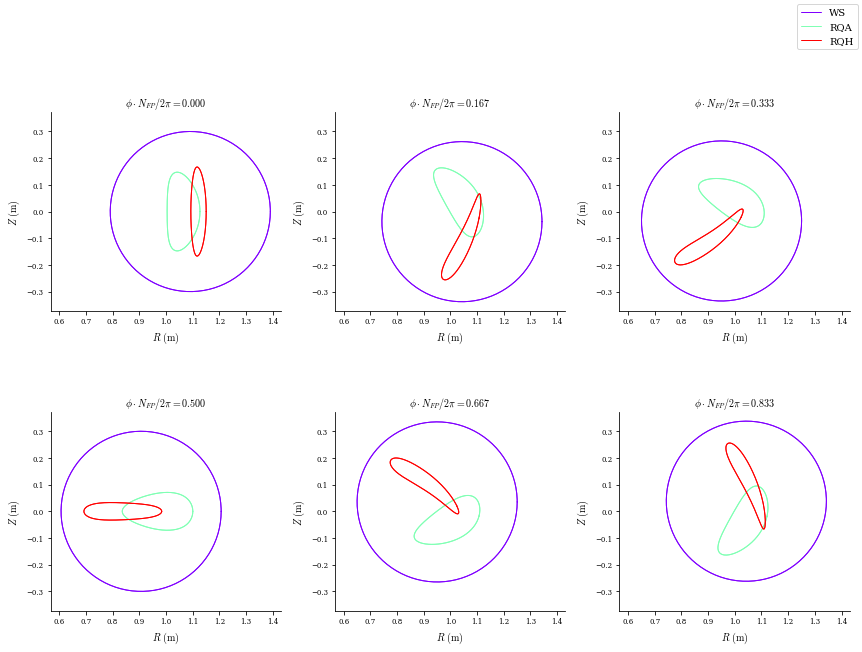

In [8]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [9]:
surf1.I

0.0

In [10]:
surf2.I

0.0

In [11]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [12]:
# Grids
Megrid = 11
Negrid = 10

Msgrid = 11
Nsgrid = 11

egrid = LinearGrid(M=Megrid,N=Negrid,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   NFP=eq.NFP,
                   sym=False) 

In [13]:
surf1.NFP

3

In [14]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [15]:
flux_QA = QuadraticFlux(eq_QA,
                        surf1,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 4,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,
                        surf2,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 4,
                        name="Bn error  eq_QH")

In [16]:
# Distance target
min_QA = 0.1
max_QA = 0.5

min_QH = 0.1
max_QH = 0.5#1#0.28

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 5,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf2,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 5,
    name="distance error  RQH"
)

In [17]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-1,1),
    weight=1e-2,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [18]:
obj_prin_curv = PrincipalCurvature(surf1,
        #target=None,
        bounds=(-15,-10),
        weight=2e0,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [19]:
Jmax = 5e7 # max current density 50 MA/m2
tmax = 2e-1 # max thickness desired for coils: 10 cm

b_M = 10
b_N = 10

obj_thickness_QA = bRegularization_fd(surf1,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 1,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QA",
                                              )

obj_thickness_QH = bRegularization_fd(surf2,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 1,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QH",
                                              )

In [20]:
obj = ObjectiveFunction((flux_QA,
                         flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         #obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         obj_thickness_QA,
                         obj_thickness_QH,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    FixParameters(surf2,{"G":True,}),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [21]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [22]:
# Run optimization
(surf1, surf2),_ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=20,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 options={"initial_trust_radius":np.inf})

Building objective: Bn error  eq_QA
Precomputing transforms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Timer: Precomputing transforms = 1.18 sec
Building objective: Bn error  eq_QH
Precomputing transforms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Timer: Precomputing transforms = 45.7 ms
Building objective: distance error  RQA
Precomputing transforms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Timer: Precomputing transforms = 135 ms
Building objective: distance error  RQH
Precomputing transforms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Timer: Precomputing transforms = 35.4 ms
Building objective: Coil Thickness Regularization: QA
Precomputing transforms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Timer: Precomputing transforms = 225 ms
Building objective: Coil Thickness Regularization: QH
Precomputing transforms
<class 'numpy.ndarray'>
<class '

/home/fcastro/DESC/desc/optimize/least_squares.py:346: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


       1              2          4.980e+03      0.000e+00      0.000e+00      9.348e+03   


/home/fcastro/DESC/desc/optimize/least_squares.py:346: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


       2              3          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
       3              4          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
       4              5          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
       5              6          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
       6              7          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
       7              8          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
       8              9          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
       9             10          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
      10             11          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
      11             12          4.980e+03      0.000e+00      0.000e+00      9.348e+03   
      12             13          4.980e+03      0.000e+00      0.000e+00      9.348e+03   

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

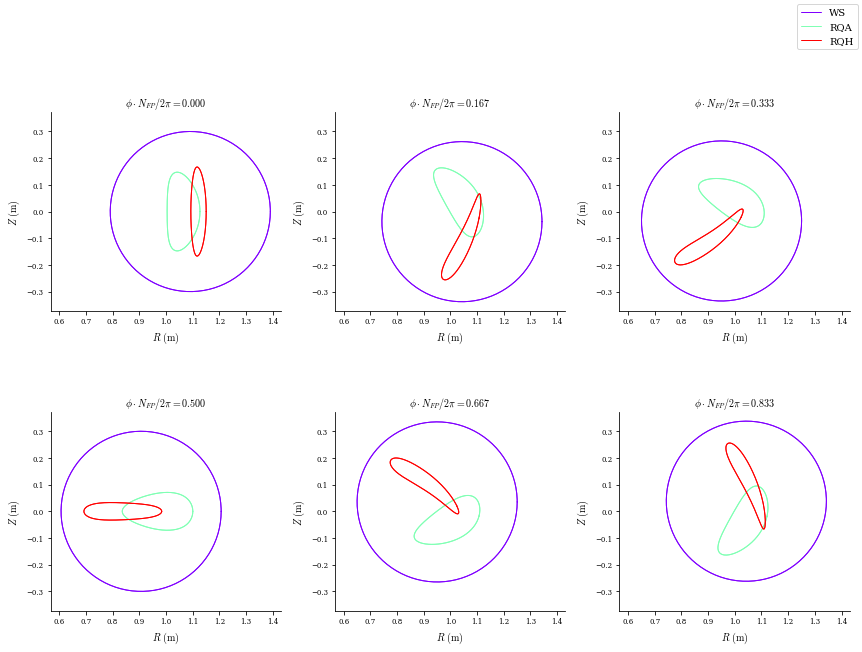

In [23]:
plot_comparison([surf1,
                 eq_QA,
                 eq_QH
                ],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [24]:
#surf1.save("surf_opt.h5")

In [25]:
surf1.I

0.0

In [26]:
surf2.I

0.0

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

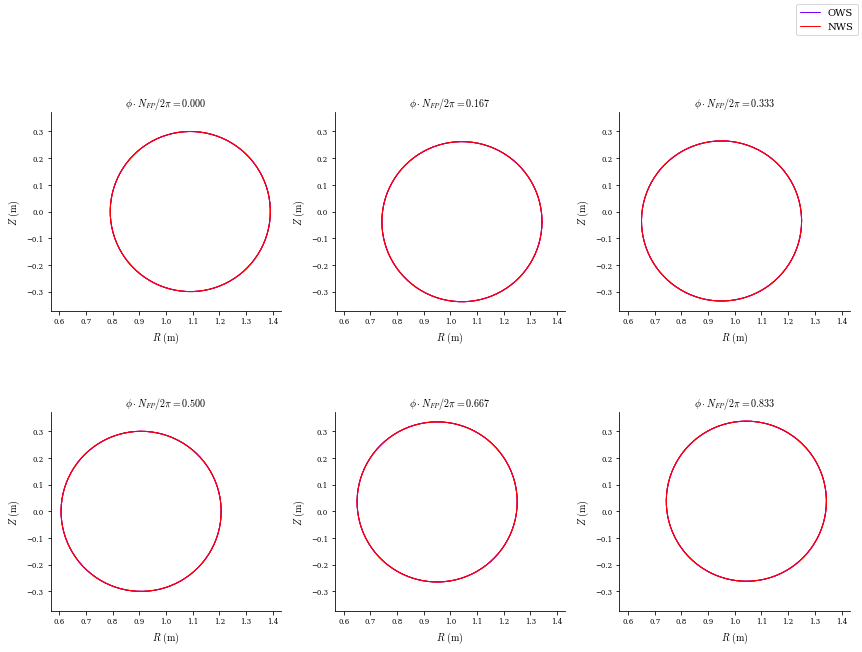

In [27]:
plot_comparison([surf,surf1],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'K surf2')

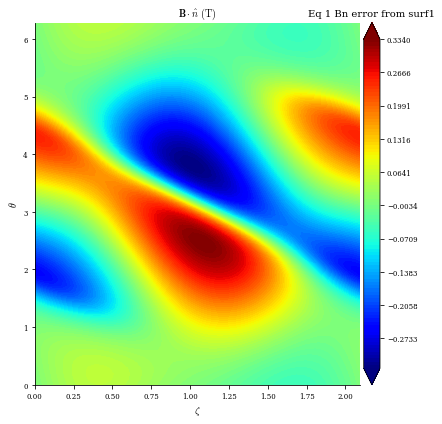

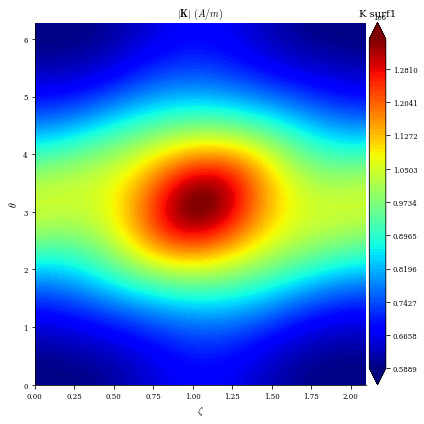

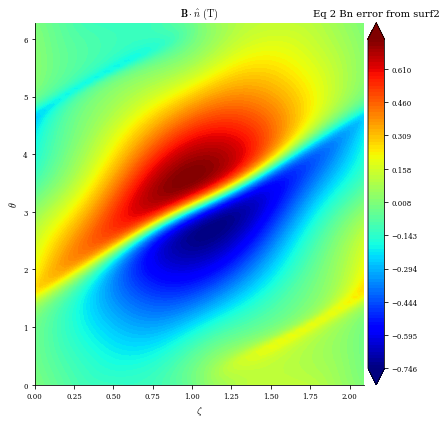

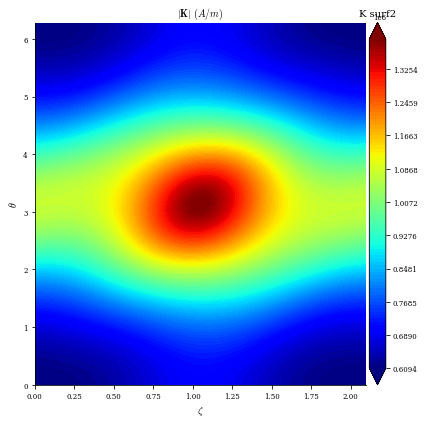

In [28]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=60,N=60,
                                NFP=eq_QA.NFP
                               )
plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "K")
plt.title("K surf1")

plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")

plot_2d(surf2, "K")
plt.title("K surf2")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


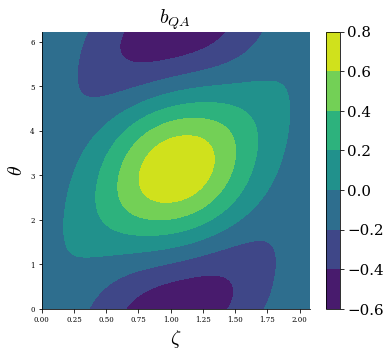

In [29]:
b_QA = surf1.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QA,
            denser_source_grid,
            ''r'$b_{QA}$ '
           )

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


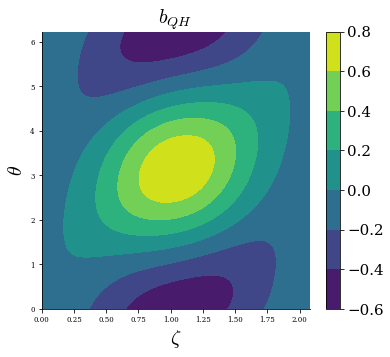

In [30]:
b_QH = surf2.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QH,
            denser_source_grid,
            ''r'$b_{QH}$ '
           )